In [1]:
# --- Setting up prerequisites libraries ---
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 11)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# --- Load the data from the web into R ---
dataset_url <- "https://github.com/eshuaiii/dsci-100-2022w1-group-79/raw/main/data/SpotifyAudioFeaturesApril2019.csv"

# read dataset from URL
spotify_original <- read_csv(url(dataset_url))

# read the first 5 rows
head(spotify_original, 5)

Rows: 130663 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): artist_name, track_id, track_name
dbl (14): acousticness, danceability, duration_ms, energy, instrumentalness,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",5.82e-03,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),2.44e-02,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,2.50e-02,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,2.94e-02,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,3.52e-05,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [3]:
set.seed(79)
# randomly obtain a sample with size of 2079 observations and do the data split
# the proportion for splitting is the group number of us
spotify_split <- spotify_original |>
                 sample_n(2079) |>
                 initial_split(prop = 0.79, strata = danceability)
# create training set and the test set
spotify_training <- training(spotify_split)
spotify_testing <- testing(spotify_split)
# check the head of the trainging set 
head(spotify_training, 5)

artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sneakbo,1yMrHwFcakcWf9t50sWhuJ,Get to Know Me,0.09440,0.432,247582,0.597,0.0000,0,0.283,-7.734,1,0.1650,104.448,4,0.203,38
Mom Jeans.,6LaJzttfJzxwmbzlKqAqDw,Edward 40hands - Audiotree Live Version,0.00012,0.235,252869,0.866,0.0109,9,0.106,-6.429,1,0.0538,177.265,4,0.338,33
Miu Chu,46x0cqQBjOT1T16N6XTGwm,我懂你的獨特,0.68900,0.391,265976,0.403,0.0000,1,0.108,-7.272,1,0.0306,135.935,4,0.157,29
Robert Schumann,0dON9pTOo2e56fdpE8aoDR,"Piano Concerto in A Minor, Op.54: 2. Intermezzo (Andantino grazioso) - Live",0.98900,0.311,277463,0.084,0.7320,5,0.189,-23.293,1,0.0350,106.178,4,0.131,35
LVNDSCAPE,6RjnrYo3B3cDceAf3UvK5w,Riot (Lo Lo Loco) [feat. Alida],0.01260,0.438,189535,0.714,0.0279,7,0.190,-5.550,0,0.0726,160.103,4,0.369,63


In [4]:
# the first stage of filtering the data needed for the regression model
# select continuous and categorical variables.

# since we might conduct cross-validation to compare this model with others in future, 
# and a categorical variable with many levels will greatly affect the performance of it
# so the variable "key" is removed, and also intuitively the time signature is not quite
# related to the danceability, and so it is removed as well


spotify_training_filter_stage_1 <- spotify_training|>
                                   select(danceability, acousticness, duration_ms, energy, instrumentalness, key, 
                                          liveness, loudness, mode, speechiness, tempo, time_signature, valence, popularity)|>
                                   select(-key, -time_signature)                                

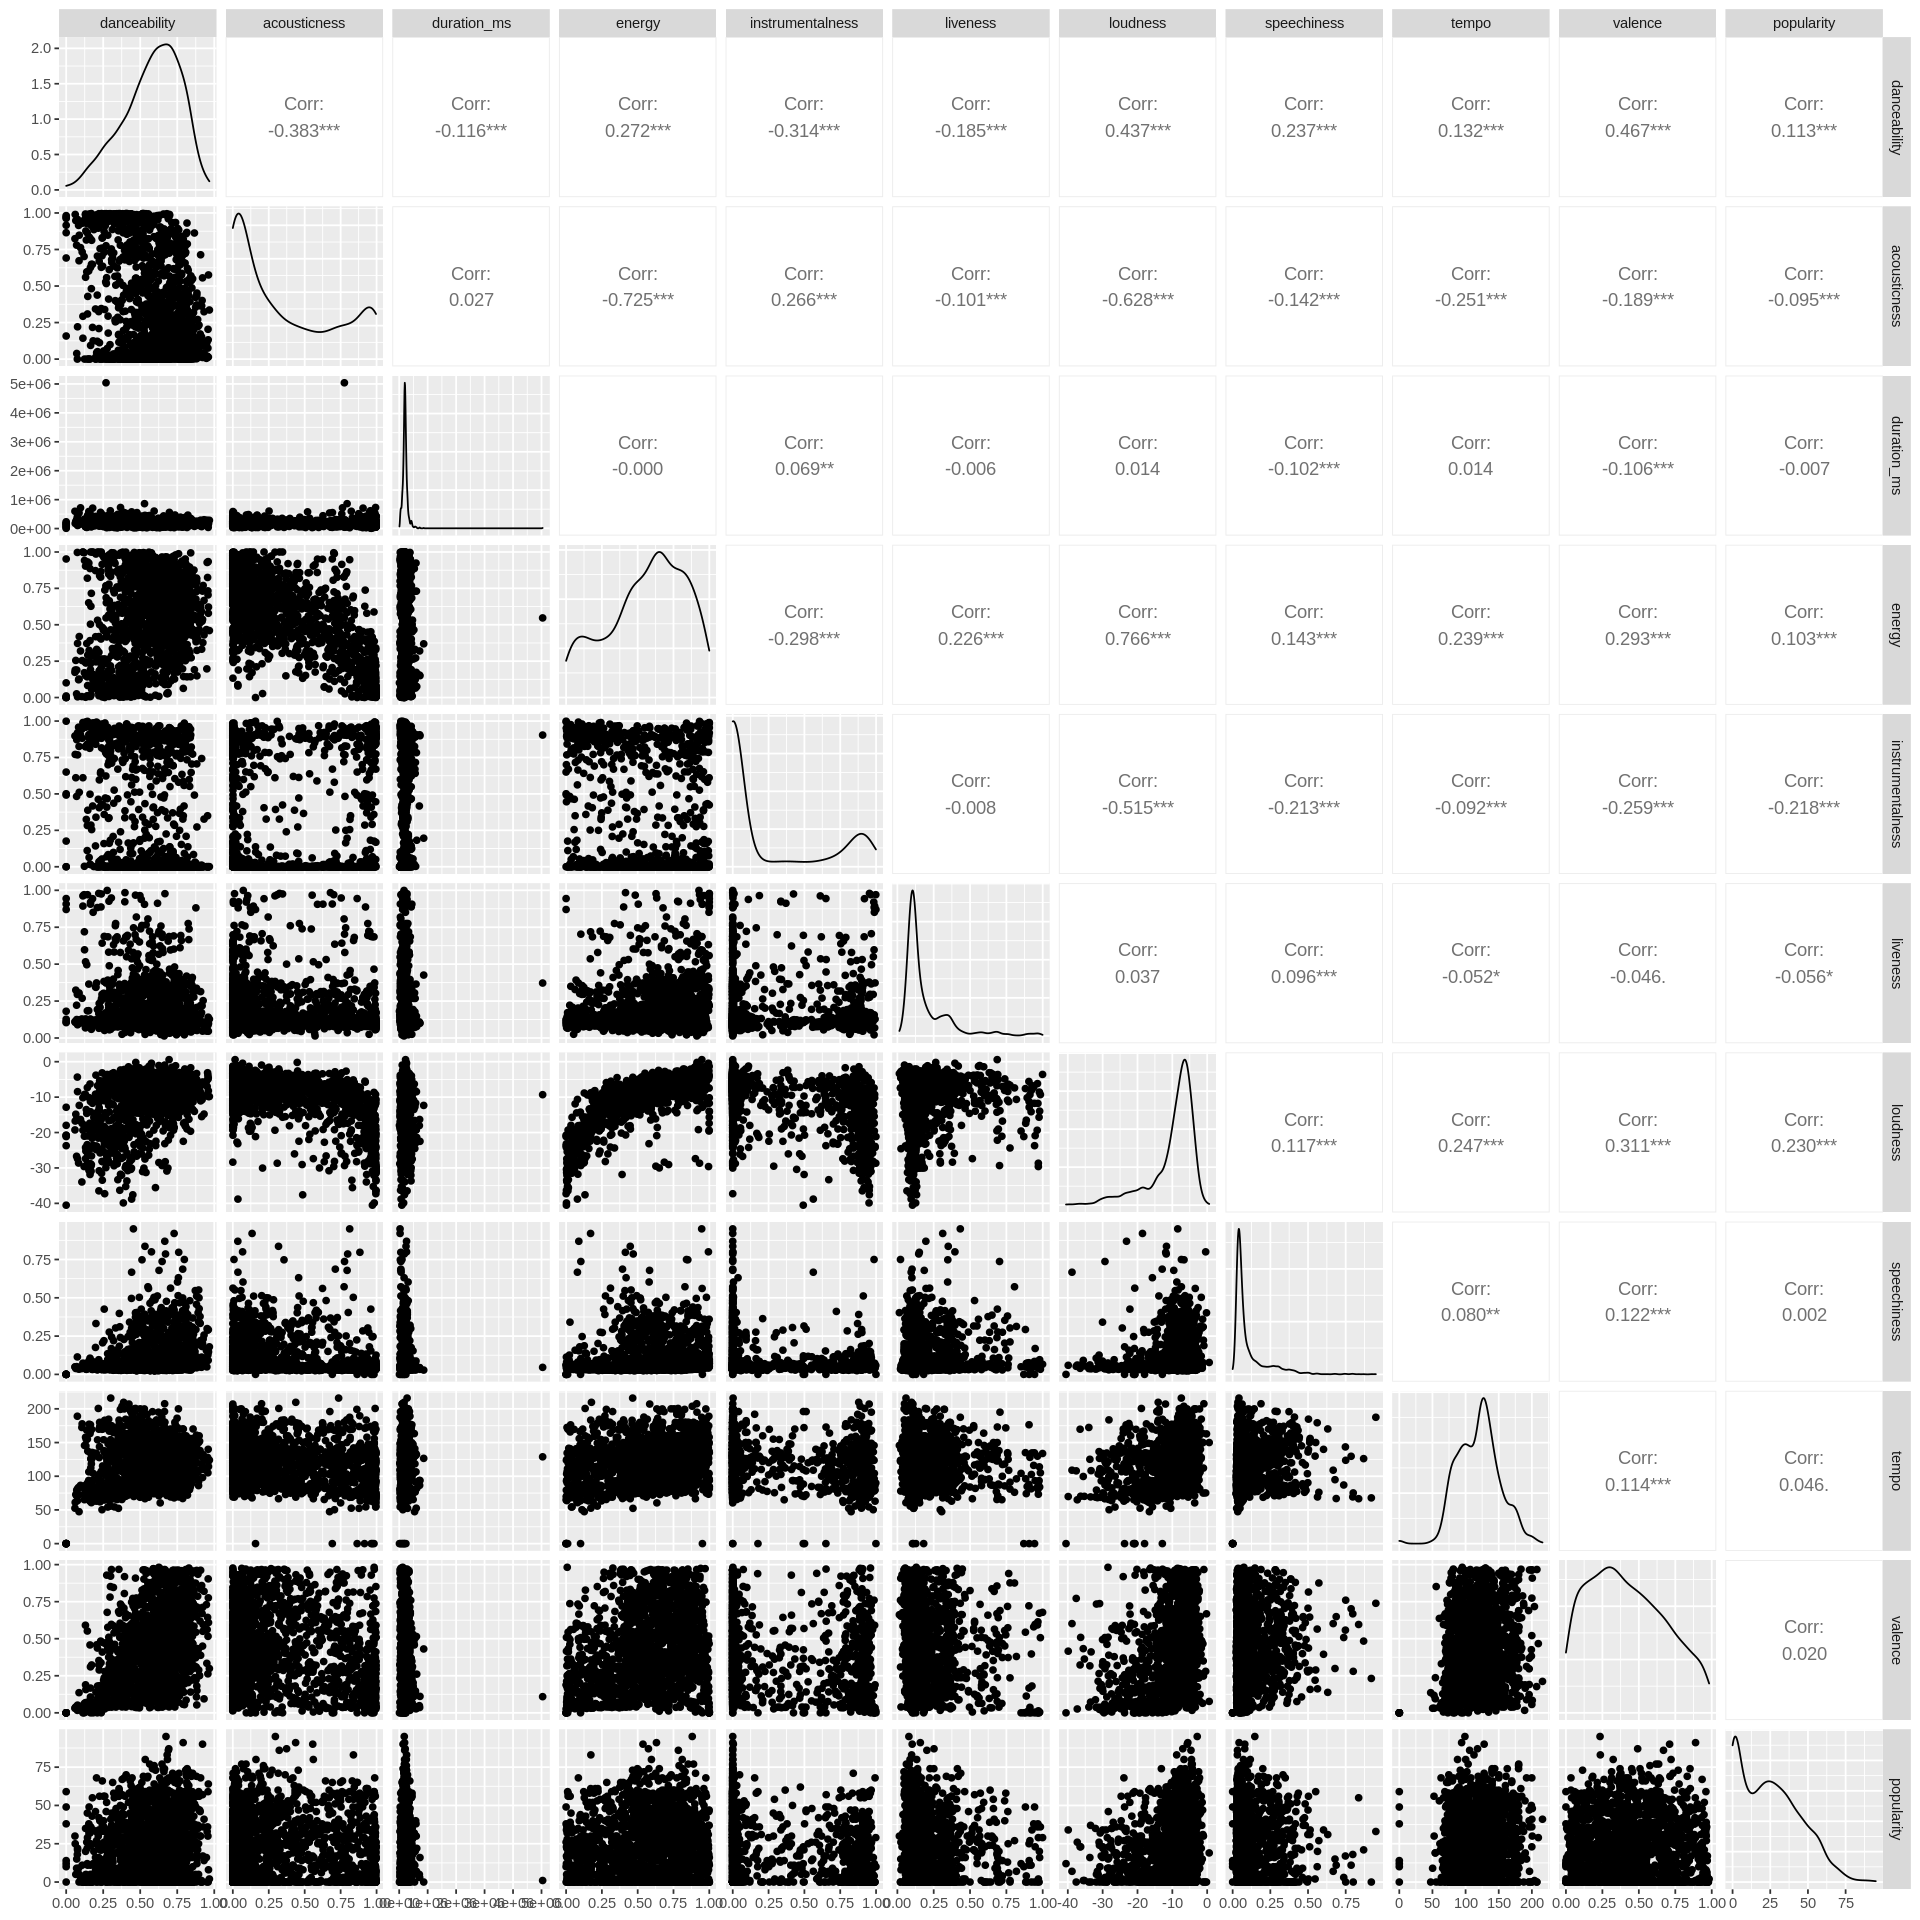

In [5]:
# the second stage of filtering the data needed for the regression model   
# for the continuous variables, we utilize the ggpairs() and the correlation matrix to
# to check the strength of relationship between each variable with danceability
# the variable "mode" is the only categorical variable that left

options(repr.plot.width = 16, repr.plot.height = 16)
spotify_training_continuous <- spotify_training_filter_stage_1 |> select(-mode)
relationship_check_graph <- ggpairs(spotify_training_continuous)
relationship_check_matrix <- cor(spotify_training_continuous)

# show the plot
relationship_check_graph

In [6]:
# show the matrix
relationship_check_matrix

,danceability,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
danceability,1.0000000,-0.38323150,-0.1155252156,0.2724606734,-0.31386384,-0.184661588,0.43677671,0.23726575,0.13184252,0.46716807,0.112781115
acousticness,-0.3832315,1.00000000,0.0274387136,-0.7252277922,0.26624236,-0.100734859,-0.62828454,-0.14151120,-0.25147012,-0.18918865,-0.094746223
duration_ms,-0.1155252,0.02743871,1.0000000000,-0.0001822095,0.06919556,-0.005859682,0.01391355,-0.10240788,0.01436104,-0.10574150,-0.006907994
energy,0.2724607,-0.72522779,-0.0001822095,1.0000000000,-0.29761067,0.226306307,0.76646665,0.14348722,0.23926380,0.29275908,0.102685160
instrumentalness,-0.3138638,0.26624236,0.0691955631,-0.2976106704,1.00000000,-0.007677070,-0.51461377,-0.21301777,-0.09215494,-0.25897419,-0.217804890
liveness,-0.1846616,-0.10073486,-0.0058596822,0.2263063066,-0.00767707,1.000000000,0.03738494,0.09580455,-0.05248413,-0.04634975,-0.056162835
loudness,0.4367767,-0.62828454,0.0139135450,0.7664666527,-0.51461377,0.037384940,1.00000000,0.11736052,0.24664228,0.31125319,0.229587706
speechiness,0.2372658,-0.14151120,-0.1024078832,0.1434872193,-0.21301777,0.095804551,0.11736052,1.00000000,0.08028547,0.12155234,0.002428820
tempo,0.1318425,-0.25147012,0.0143610355,0.2392637952,-0.09215494,-0.052484133,0.24664228,0.08028547,1.00000000,0.11398943,0.046276176
valence,0.4671681,-0.18918865,-0.1057414959,0.2927590800,-0.25897419,-0.046349754,0.31125319,0.12155234,0.11398943,1.00000000,0.019813237


In [7]:
# the first stage of filtering the data needed for the regression model

# based on the plot and graph, especially the correlation between each continuous predictor with danceability
# we select acousticness, loudness, valence, instrumentalness, and energy (as well as mode)
# as the potential variables that are necessary to make prediction on danceability

spotify_training_filter_stage_2 <- spotify_training_filter_stage_1 |>
                                  select(danceability, acousticness, loudness,
                                         valence, instrumentalness, energy, mode)

# check the existence of NA value and obtain the ultimate cleaned trainging data
spotify_training_NA_indicator <- spotify_training_filter_stage_2 |> complete.cases()
spotify_training_cleaned <- spotify_training_filter_stage_2[spotify_training_NA_indicator,]

# check the head of spotify_training_cleaned
head(spotify_training_cleaned)

danceability,acousticness,loudness,valence,instrumentalness,energy,mode
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.432,0.094400,-7.734,0.203,0.00000,0.597,1
0.235,0.000120,-6.429,0.338,0.01090,0.866,1
0.391,0.689000,-7.272,0.157,0.00000,0.403,1
0.311,0.989000,-23.293,0.131,0.73200,0.084,1
0.438,0.012600,-5.550,0.369,0.02790,0.714,0
0.443,0.000119,-3.838,0.264,0.00235,0.977,0


In [8]:
# we are not going to center and scale the data since it will not affect the performance of the linear regression

# however, considering that there is no single variable that has a correlation coefficient larger than 0.5
# with the danceability, it will be quite arbitrary and unvalid to use the full model or a random subset of
# the predictors directly, and thus we would conduct greedy selection to find the best subset of variables

# specfically, since the dimension here is not so high, we will not use the "forward selection" version, but the "all subsets" version

library(leaps)
full_model <- regsubsets(danceability ~ ., data = spotify_training_cleaned)
# show the best models under each dimension
summary(full_model)

Subset selection object
Call: regsubsets.formula(danceability ~ ., data = spotify_training_cleaned)
6 Variables  (and intercept)
                 Forced in Forced out
acousticness         FALSE      FALSE
loudness             FALSE      FALSE
valence              FALSE      FALSE
instrumentalness     FALSE      FALSE
energy               FALSE      FALSE
mode                 FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         acousticness loudness valence instrumentalness energy mode
1  ( 1 ) " "          " "      "*"     " "              " "    " " 
2  ( 1 ) " "          "*"      "*"     " "              " "    " " 
3  ( 1 ) "*"          "*"      "*"     " "              " "    " " 
4  ( 1 ) "*"          "*"      "*"     " "              "*"    " " 
5  ( 1 ) "*"          "*"      "*"     " "              "*"    "*" 
6  ( 1 ) "*"          "*"      "*"     "*"              "*"    "*" 

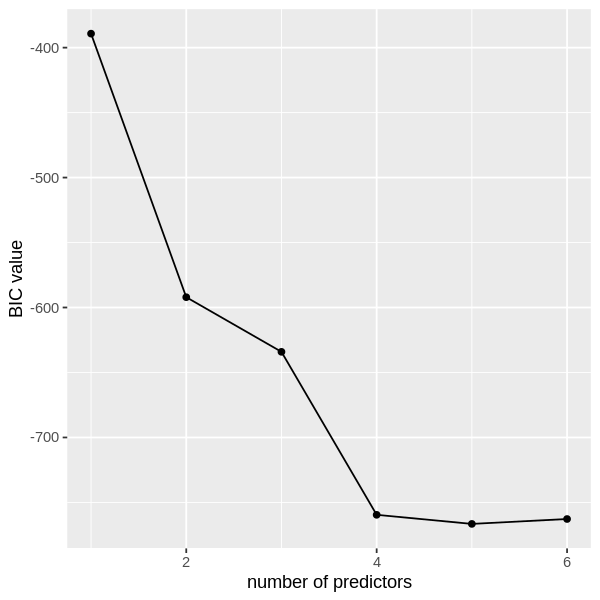

In [9]:
# now we are going to pick the best model under all dimensions
# similar to cross-validation, BIC or Mallow's Cp value are also critertion that estimate the predition error
# therefore, we are going to BIC accross all the potential best models to pick the final one

BIC_tibble <- tibble(number_of_predictors = 1:6,
                     BIC_value = summary(full_model)$bic)

# plot the BIC value against dimension
BIC_plot <- ggplot(data = BIC_tibble,
                   aes(x=number_of_predictors,
                       y=BIC_value))+
            geom_point()+
            geom_line()+
            labs(x="number of predictors", y="BIC value")
options(repr.plot.width = 5, repr.plot.height = 5)
BIC_plot

In [10]:
# since the BIC value is an estimate of the predicton error, we prefer a lower BIC value
# and thus the optimal dimension by BIC should be 5
# based on the summary of our greedy selection, the predictors we should include are
# all but instrumentalness

spotify_training_optimal <- spotify_training_cleaned |> select(-instrumentalness)
optimal_model <- lm(danceability~., data = spotify_training_optimal)

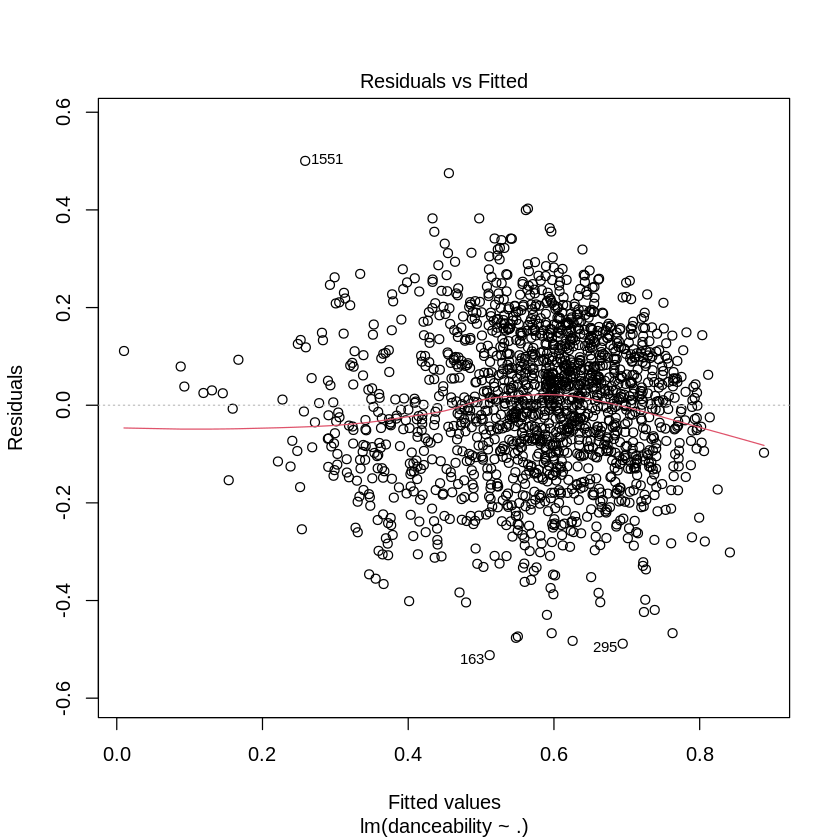

NULL

NULL

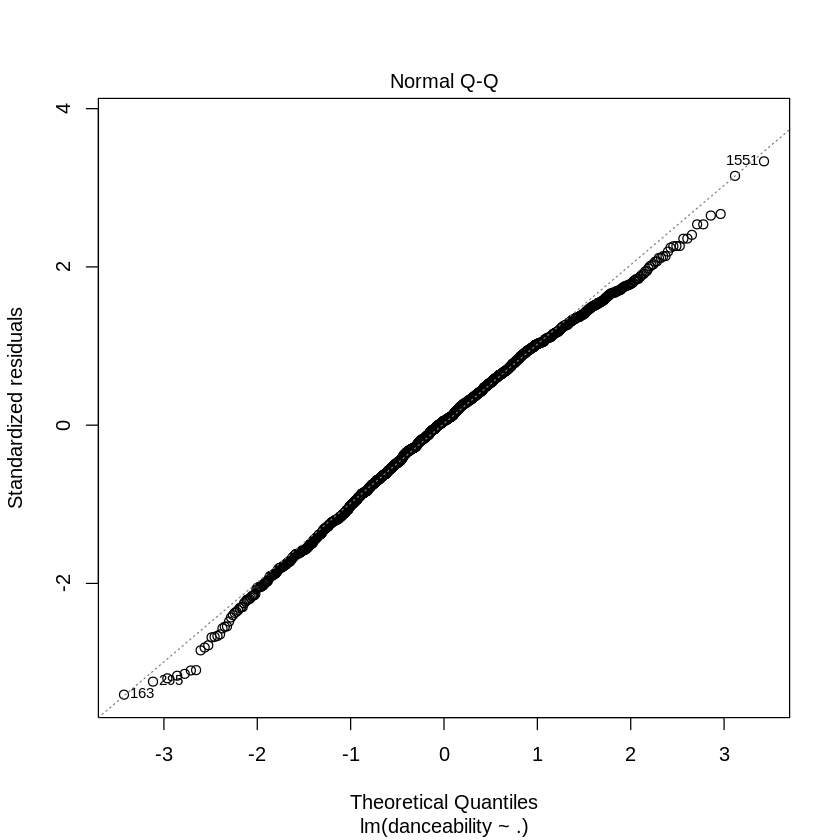

In [11]:
# check the residual plot and qqplot, so as to test the special pattern of data
# and the normality of residuals
options(repr.plot.width = 7, repr.plot.height = 7)
residual_plot <- plot(optimal_model, which = 1)
ggplot <- plot(optimal_model, which = 2)
residual_plot
ggplot

In [12]:
# since there is no apparent pattern of residuals and the qqplot is approximately a straight line
# the validity of the model is proven approximately

# then we are going to check the performance of the model on the test set
prediction_test <- predict(optimal_model, newdata = spotify_testing) |> as_tibble()
colnames(prediction_test) <- c("prediction")
# then append the prediction result to the original testing set
spotify_testing_complete <- cbind(spotify_testing, prediction_test)
# compute the rmse on the training set
RMSE_regression <- with(spotify_testing_complete, sqrt(mean((prediction-danceability)^2)))
RMSE_regression

[1] 0.1550544

In [13]:
# However, there are some limitations of the current optimal regression model

# firstly, we didn't do any feature mapping and generation procedure, and thus it is possible that we can 
# improve our model further by adding more quadratic terms or interaction terms

# secondly, we are using BIC criterion as an estimate of prediction error, and 
# there are actually multiple choices of it, so we change the way of estimating then the result might be 
# slightly different.

# thirdly, the first stage of filtering is conducted under intuition, and so actually some of the useful information
# might have been ignored.

